# Oct 12-15,21, 2023: estimate functional networks: runwise

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.parcel_name = 'whole'
args.rois_folder = 'yale_172' # 'hadi_1445'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
TS_path = f'{BASE_path}/{args.rois_folder}/roi_timeseries_txt_files/{args.parcel_name}'
FC_path = f'{BASE_path}/{args.rois_folder}/func_nws_files/{args.parcel_name}'
cmd = (
    f'mkdir -p {FC_path}'
)
os.system(cmd)
NPY_path = f'{BASE_path}/{args.rois_folder}/npy_files'
cmd = (
    f'mkdir -p {NPY_path}'
)
os.system(cmd)

0

In [4]:
hadi_1445_rois = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
)

yale_172_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_roi_labels.txt'
)

In [5]:
# runwise FCs 
args.num_subs = 10
args.num_sess = 3
args.num_rois = len(np.loadtxt(yale_172_rois).astype(int))
args.percentile = 90
main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    # run = int(fs[2].split('-')[-1])
    main_sample[sub-1][ses-1].append(file)

for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [6]:
args.num_rois

172

In [7]:
fcs = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in main_sample[sub][ses]:
        ts = np.loadtxt(f'{TS_path}/{run}')
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        fc = np.corrcoef(ts, rowvar=False)
        fc = fc[np.tril_indices(fc.shape[0], k=-1)]
        fc[np.isnan(fc)] = 0.0
        fc = fc > np.percentile(fc, q=args.percentile) # keep only top 10% edges, this removes neg. edges
        
        fc_ = np.zeros((args.num_rois, args.num_rois))
        fc_[np.tril_indices(fc_.shape[0], k=-1)] = fc
        fc_ = (fc_ + fc_.T)
        
        fcs[sub][ses].append(fc_)
        
        edges = np.stack(np.where(np.tril(fc_, k=-1)), axis=-1)
        nw_edges_file = '_'.join(run.split('_')[:-1] + ['desc-nw-edges.txt'])
        with open(f'{FC_path}/{nw_edges_file}', 'w', newline='') as f:
            wr = csv.writer(f, delimiter='\t')
            wr.writerows(edges)
            
with open(f'{NPY_path}/func_nws_{args.parcel_name}.npy', 'wb') as f:
    pickle.dump(fcs, f)

30it [00:01, 24.13it/s]


<AxesSubplot:>

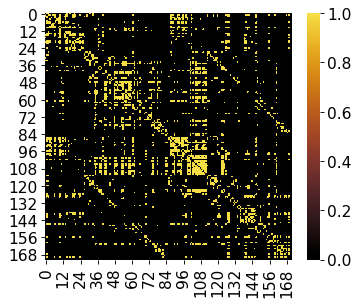

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4), dpi=80)
ax = axs
sns.heatmap(fcs[3][1][2], ax=ax, square=True, cmap=cmr.iceburn, center=0)